In [ ]:
#pip install efficientnet 

In [1]:
import gc

gc.collect()

359

# Set-up for Multi GPU

In [2]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [3]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 3070 Laptop GPU || GPU || 5.3 GiB
 /device:GPU:1 ||  NVIDIA GeForce RTX 3060 || GPU || 9.4 GiB


In [4]:
strategy = tf.distribute.MirroredStrategystrategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [5]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


# Importing the necessary libraries

In [6]:
%matplotlib inline
import pandas as pd
import numpy as np
import argparse
import locale

# load and display an image with Matplotlib
from matplotlib import image
from matplotlib import pyplot

# Libraries to help with data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import seaborn as sns
import cv2 # IMAGE PROCESSING - OPENCV

## Model Building
import sklearn     
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, auc, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

## Import Keras & Tensoflow
#from keras.utils import np_utils
import keras
import keras.layers as layers
import tensorflow.keras
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
#from tensorflow.keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam#from tensorflow.keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import * 

# Import SMOTE
#from imblearn.over_sampling import SMOTE

import cv2
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pydicom as pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from tqdm.notebook import tqdm as tqdm
import ray
import time
import gdcm

import pickle
import joblib

from PIL import Image
import glob

In [7]:
import tensorflow as tf 
print(tf. __version__)

2.7.0


In [8]:
from platform import python_version
python_version() 

'3.8.12'

In [10]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["NVIDIA_VISIBLE_DEVICES"]="1"
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import tensorflow as tf

tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9165729648399854032
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5734662144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7873008536645398765
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 10065281024
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15212100220249339379
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:04:00.0, compute capability: 8.6"
xla_global_id: 2144165316
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [11]:
# check Pillow version number
import PIL
print('Pillow Version:', PIL.__version__)

Pillow Version: 9.0.0


# Reading the dataset

In [12]:
def read_xray(
        path: str,
        voi_lut: bool=False,
        fix_monochrome: bool=True
):
    dicom = pydicom.read_file(path)

    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array

    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data

    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)

    return data

def resize_img(
    img: np.array,
    image_size: int,
):
    height, width = img.shape[:2]
    scale = image_size / min(width, height)
    w = int(width * scale + 0.5)
    h = int(height * scale + 0.5)
    if scale > 1.0:
        interpolation=cv2.INTER_CUBIC
    else:
        interpolation=cv2.INTER_AREA

    return cv2.resize(img, (w, h), interpolation=interpolation)

In [13]:
size = 512

input_dir = "C:\Kaggle\Mammogram"
output_dir = "C:\Kaggle\Mammogram\output\train"

df = pd.read_csv(os.path.join(input_dir, "train.csv"))
image_ids = df["image_id"].unique()


In [14]:
len(df["image_id"].unique())

54706

In [15]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [16]:
#drop column not into test data
df.drop('biopsy', axis=1, inplace=True)
df.drop('invasive', axis=1, inplace=True)
df.drop('BIRADS', axis=1, inplace=True)
df.drop('density', axis=1, inplace=True)
df.drop('difficult_negative_case', axis=1, inplace=True)

In [17]:
filenames = list()

def datSetGenerator(path):
    index = 0
    image_list = []
    for filename in glob.glob(path+'*.jpg'):
        image_list.append(cv2.resize(cv2.imread(filename),(64, 64))/255)
        filenames.append(filename)
        index += 1
        if index == 500000:
            break
    return np.array(image_list)


if __name__ == '__main__':

    # for testing the generator
    path = "C:\\Kaggle\\Mammogram\\output\\train/"
    #path = "/home/project/train_images/"
    images = datSetGenerator(path)
    print("\n data shape :",images.shape)



 data shape : (54706, 64, 64, 3)


In [18]:
images

array([[[[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [19]:
images.shape

(54706, 64, 64, 3)

In [20]:
print(images.dtype)

float64


# Overview of the dataset

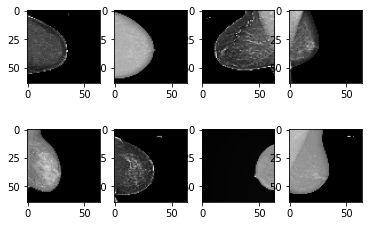

In [34]:
# Show some example images
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])

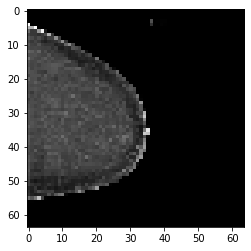

In [35]:
plt.imshow(images[0], cmap='gray')

In [36]:
print('The shape of image is: ', images[0].shape)
# Extracting the height and width of an image 
h, w = images[0].shape[:2] 
# Displaying the height and width 
print("Height = {},  Width = {}".format(h, w)) 

The shape of image is:  (64, 64, 3)
Height = 64,  Width = 64


C:\Users\frede\anaconda3\envs\gpu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1]), [Text(0, 0, '0'), Text(1, 0, '1')])

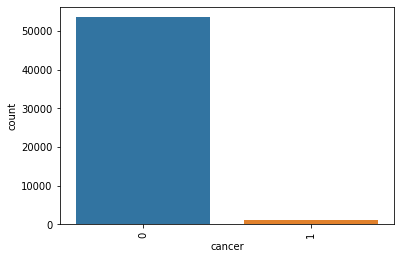

In [37]:
# Let's have a look if the dataset is imbalanced or not

sns.countplot(df['cancer'])
plt.xticks(rotation='vertical')

# Model Building

In [38]:
# You can also do info.splits.total_num_examples to get the total
# number of examples in the dataset.

BUFFER_SIZE = 10000

BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

### Version 2 - With Metadata 

In [39]:
df

,site_id,patient_id,image_id,laterality,view,age,cancer,implant,machine_id
0,2,10006,462822612,L,CC,61.0,0,0,29
1,2,10006,1459541791,L,MLO,61.0,0,0,29
2,2,10006,1864590858,R,MLO,61.0,0,0,29
3,2,10006,1874946579,R,CC,61.0,0,0,29
4,2,10011,220375232,L,CC,55.0,0,0,21
...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,49
54702,1,9989,63473691,L,MLO,60.0,0,0,216
54703,1,9989,1078943060,L,CC,60.0,0,0,216
54704,1,9989,398038886,R,MLO,60.0,0,0,216


In [40]:
df.isnull().any()

site_id       False
patient_id    False
image_id      False
laterality    False
view          False
age            True
cancer        False
implant       False
machine_id    False
dtype: bool

In [41]:
df[['age']] = df[['age']].transform(lambda x: x.fillna(x.median().iloc[0]))

In [45]:
## Create dummy variables

def encode_cat_vars(x):
     x = pd.get_dummies(
         x,
         columns=x.select_dtypes(include=["object", "category"]).columns.tolist(),
         drop_first=True,
     )
     return x


ind_vars_num = encode_cat_vars(df)
ind_vars_num.head()

,site_id,patient_id,image_id,age,cancer,implant,machine_id,laterality_R,view_CC,view_LM,view_LMO,view_ML,view_MLO
0,2,10006,462822612,61.0,0,0,29,0,1,0,0,0,0
1,2,10006,1459541791,61.0,0,0,29,0,0,0,0,0,1
2,2,10006,1864590858,61.0,0,0,29,1,0,0,0,0,1
3,2,10006,1874946579,61.0,0,0,29,1,1,0,0,0,0
4,2,10011,220375232,55.0,0,0,21,0,1,0,0,0,0


In [46]:
ind_vars_num.isnull().any()

site_id         False
patient_id      False
image_id        False
age             False
cancer          False
implant         False
machine_id      False
laterality_R    False
view_CC         False
view_LM         False
view_LMO        False
view_ML         False
view_MLO        False
dtype: bool

In [47]:
import gc
del df
gc.collect()

18346

In [48]:
# Branch for numerical and categorical data

def create_mlp(dim, regress=False):
    # define our MLP network
    model = Sequential()
    model.add(Dense(8, input_dim=dim, activation="relu"))
    model.add(Dense(4, activation="softmax"))
    # check to see if the regression node should be added
    if regress:
        model.add(Dense(1, activation="linear"))
    # return our model
    return model

In [49]:
# Branch for image data

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1
   
    #Add restnet layer
    #base_model = ResNet50(include_top=False, pooling='avg', weights='imagenet')
    #x = base_model.output
    
    #Add EfficientNet
    #base_model = EfficientNetB0(input_shape = inputShape, include_top = False, weights = 'imagenet')
    #x = base_model.output
    
    
    # define the model input
    inputs = Input(shape=inputShape)
    # loop over the number of filters
    for (i, f) in enumerate(filters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs
        # CONV => RELU => BN => POOL
        x = Conv2D(f, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
   
    #Add VGG16
    base_model = VGG16(input_shape = inputShape, include_top = False, weights = 'imagenet')

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer, this one to match the number of nodes
    # coming out of the MLP
    x = Dense(4)(x)
    x = Activation("sigmoid")(x)
    
    # check to see if the regression node should be added
    if regress:
        x = Dense(1, activation="linear")(x)
    
    # construct the CNN
    model = Model(inputs, x)
    
    # return the CNN
    return model

In [52]:
# partition the data into training and testing splits using 70% of
# the data for training and the remaining 30% for testing
print("[INFO] processing data...")
split = train_test_split(ind_vars_num, images, test_size=0.3, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

trainY = trainAttrX["cancer"]
testY = testAttrX["cancer"]


[INFO] processing data...


In [53]:
trainAttrX.drop('cancer', axis=1, inplace=True)
testAttrX.drop('cancer', axis=1, inplace=True)

In [54]:
trainY.unique()

array([0, 1], dtype=int64)

In [55]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(trainY),y = trainY) 
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5108182376010458, 1: 23.60912453760789}

In [56]:
import models

In [57]:
models

<module 'models' from 'C:\\Users\\frede\\Documents\\models.py'>

In [58]:
with strategy.scope():
   
    # create the MLP and CNN models
    mlp = models.create_mlp(trainAttrX.shape[1], regress=False)
    cnn = models.create_cnn(64, 64, 3, regress=False)

    # create the input to our final set of layers as the *output* of both
    # the MLP and CNN
    combinedInput = concatenate([mlp.output, cnn.output])
   

    # our final FC layer head will have two dense layers, the final one
    # being our regression head
    x = Dense(2, activation="relu")(combinedInput)
    x = Dense(1, activation="sigmoid")(x)

    # our final model will accept categorical/numerical data on the MLP
    # input and images on the CNN input, outputting a single value (the
    # predicted price of the house)
    model = Model(inputs=[mlp.input, cnn.input], outputs=x)

    # compile the model using mean absolute percentage error as our loss,
    # implying that we seek to minimize the absolute percentage difference
    # between our price *predictions* and the *actual prices*
    #opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile(loss="binary_crossentropy", optimizer=opt, metrics = [tf.keras.metrics.AUC()])

    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    
    # train the model
    print("[INFO] training model...")

    model.fit(
        x=[trainAttrX, trainImagesX], y=trainY,
        validation_data=([testAttrX, testImagesX], testY),
        epochs=3, batch_size=10, class_weight=class_weights, callbacks=[es, mc], use_multiprocessing=True)

    # make predictions on the testing data
    print("[INFO] predicting house prices...")
    preds = model.predict([testAttrX, testImagesX])
    
    # compute the difference between the *predicted* house prices and the
    # *actual* house prices, then compute the percentage difference and
    # the absolute percentage difference
    #diff = preds.flatten() - testY
    #percentDiff = (diff / testY) * 100
    #absPercentDiff = np.abs(percentDiff)

    # compute the mean and standard deviation of the absolute percentage
    # difference
    #mean = np.mean(absPercentDiff)
    #std = np.std(absPercentDiff)

    # finally, show some statistics on our model
    #locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
    #print("[INFO] avg. house price: {}, std house price: {}".format(
    #    locale.currency(df["price"].mean(), grouping=True),
    #    locale.currency(df["price"].std(), grouping=True)))
    #print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

C:\Users\frede\anaconda3\envs\gpu\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Epoch 1/3
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1
INFO:tensorflow:batch_all_reduce: 26 all-reduces with algorithm = hierarchical_copy, num_packs = 1
3830/3830 [==============================] - 88s 21ms/step - loss: 0.7225 - auc: 0.5176 - val_loss: 0.6053 - val_auc: 0.5149
Epoch 2/3
3830/3830 [==============================] - 79s 21ms/step - loss: 0.7066 - auc: 0.5022 - val_loss: 0.6508 - val_auc: 0.4849
Epoch 3/3
3830/3830 [==============================] - 81s 21ms/step - loss: 0.7036 - auc: 0.4994 - val_loss: 0.6865 - val_auc: 0.4999
[INFO] predicting house prices...
Instructions for updating:
use `experimental_local_results` instead.


In [61]:
np.unique(preds, axis=0)

array([[0.47401643],
       [0.47401696],
       [0.47401702],
       [0.4740173 ],
       [0.4740176 ],
       [0.47401813],
       [0.4740216 ],
       [0.47402242],
       [0.47402263],
       [0.47404644],
       [0.47410023],
       [0.4741303 ],
       [0.47611633],
       [0.47852966],
       [0.4876457 ],
       [0.49231693],
       [0.4964383 ],
       [0.49643835],
       [0.4964384 ],
       [0.49643847],
       [0.49643853],
       [0.49643865],
       [0.496451  ],
       [0.49645442],
       [0.49648085],
       [0.49665415],
       [0.49668   ],
       [0.4980954 ],
       [0.5013813 ],
       [0.5018449 ],
       [0.5020913 ],
       [0.5050602 ],
       [0.59013474]], dtype=float32)

In [62]:
model.save('C:\Kaggle\Mammogram\submission/my_model')

INFO:tensorflow:Assets written to: C:\Kaggle\Mammogram\submission/my_model\assets
